In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [5]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import random

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Model değerlendirme
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Grad-CAM için
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.cm as cm

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## 📂 Veri Seti Klasör Yapısını İnceleme

Bu kod, verilen bir klasörün yapısını hiyerarşik şekilde ekrana yazdırır.  

- `data_dir`: Veri seti yolunu tanımlar.  
- `explore_dataset(directory)`:  
  - `os.walk()` ile klasörleri ve dosyaları dolaşır.  
  - Her klasörün seviyesine göre girinti (indent) ekler.  
  - Her klasörde **ilk 3 dosyayı** gösterir.  
  - Eğer daha fazla dosya varsa, kalan sayıyı özetler.  

Örnek çıktı:  

brain-tumor-mri-dataset/
yes/
Y1.jpg
Y2.jpg
Y3.jpg
... ve 1 dosya daha
no/
N1.jpg
N2.jpg

In [11]:
# Veri seti yolunu tanımla
data_dir = "/kaggle/input/brain-tumor-mri-dataset"

# Klasör yapısını incele
def explore_dataset(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)  # Mevcut klasörün seviyesini hesapla
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # İlk 3 dosyayı göster
            print(f"{sub_indent}{file}")
        if len(files) > 3:
            print(f"{sub_indent}... ve {len(files) - 3} dosya daha")

explore_dataset(data_dir)

brain-tumor-mri-dataset/
  Training/
    pituitary/
      Tr-pi_0532.jpg
      Tr-pi_0282.jpg
      Tr-pi_1401.jpg
      ... ve 1454 dosya daha
    notumor/
      Tr-no_0482.jpg
      Tr-no_0641.jpg
      Tr-no_0592.jpg
      ... ve 1592 dosya daha
    meningioma/
      Tr-me_0529.jpg
      Tr-me_1256.jpg
      Tr-me_0852.jpg
      ... ve 1336 dosya daha
    glioma/
      Tr-gl_0954.jpg
      Tr-gl_0959.jpg
      Tr-gl_1033.jpg
      ... ve 1318 dosya daha
  Testing/
    pituitary/
      Te-pi_0059.jpg
      Te-pi_0024.jpg
      Te-pi_0232.jpg
      ... ve 297 dosya daha
    notumor/
      Te-no_0016.jpg
      Te-no_0292.jpg
      Te-no_0137.jpg
      ... ve 402 dosya daha
    meningioma/
      Te-me_0148.jpg
      Te-me_0062.jpg
      Te-me_0303.jpg
      ... ve 303 dosya daha
    glioma/
      Te-gl_0066.jpg
      Te-gl_0043.jpg
      Te-gl_0166.jpg
      ... ve 297 dosya daha


# Training ve Testing
**Eğitim ve Test Veri Setlerindeki Sınıf Dağılımını Analiz Etmek**
Bu Python kodu, kullandığınız Beyin Tümörü MRI Veri Seti içindeki Training (Eğitim) ve Testing (Test) klasörlerindeki görüntülerin sınıflara göre nasıl dağıldığını tespit eder ve bu dağılımı görselleştirir.

*Neden Önemli? (Temel Çıkarımlar)*
Bu analiz, modelinizi eğitmeden önce veri setinizin dengeli (balanced) olup olmadığını anlamanızı sağlar.

*Dengesizlik (Imbalance)*: Eğer bir sınıf diğerlerinden çok daha fazla veya az görüntüye sahipse, modeliniz o az sayıdaki sınıfı doğru tahmin etmede zorlanabilir. Bu durum, modelinizin performansını (özellikle kesinlik/recall ve F1 skoru gibi metrikleri) yanıltabilir.

*Doğrulama:* Training ve Testing setlerindeki dağılımın benzer olup olmadığını kontrol etmek, modelinizin gerçek dünya verilerinde de iyi performans göstereceğinden emin olmanızı sağlar.

Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']


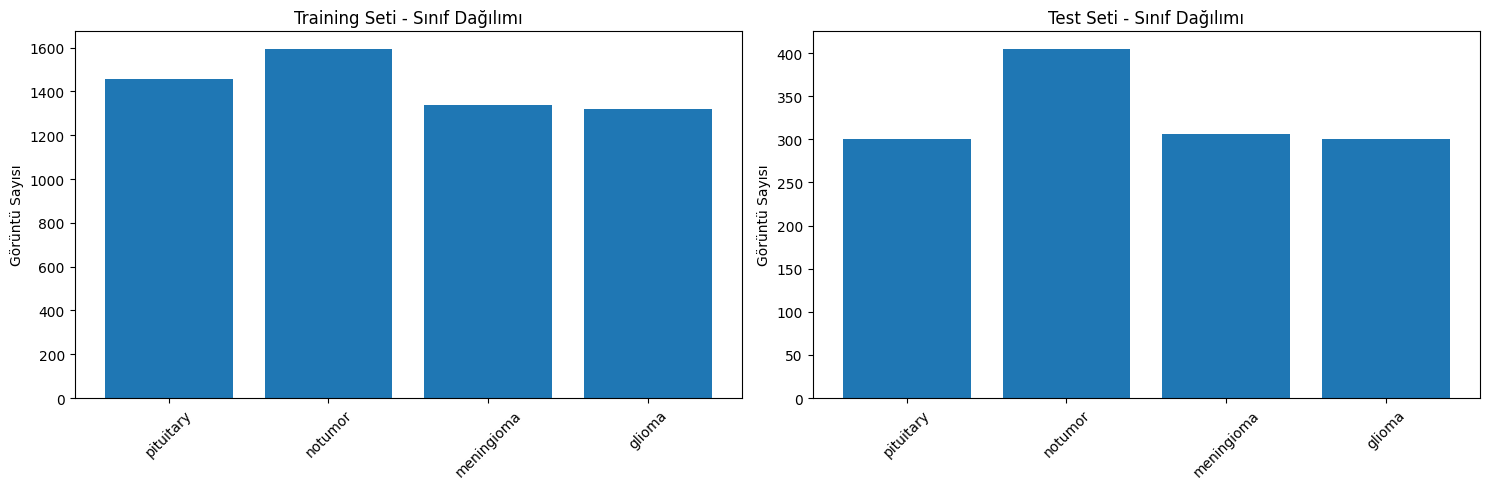

Training seti toplam görüntü: 5712
Test seti toplam görüntü: 1311


In [12]:
# Training ve Testing klasörlerindeki sınıf dağılımı
training_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
testing_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Sınıf isimlerini ve görüntü sayılarını al
class_names = os.listdir(training_path)
print("Sınıflar:", class_names)

# Görüntü sayılarını hesapla
train_counts = {}
test_counts = {}

for class_name in class_names:
    train_path = os.path.join(training_path, class_name)
    test_path = os.path.join(testing_path, class_name)
    
    train_counts[class_name] = len(os.listdir(train_path))
    test_counts[class_name] = len(os.listdir(test_path))

# Görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training dağılımı
ax1.bar(train_counts.keys(), train_counts.values())
ax1.set_title('Training Seti - Sınıf Dağılımı')
ax1.set_ylabel('Görüntü Sayısı')
ax1.tick_params(axis='x', rotation=45)

# Testing dağılımı
ax2.bar(test_counts.keys(), test_counts.values())
ax2.set_title('Test Seti - Sınıf Dağılımı')
ax2.set_ylabel('Görüntü Sayısı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Training seti toplam görüntü:", sum(train_counts.values()))
print("Test seti toplam görüntü:", sum(test_counts.values()))

*1. Sınıf İsimleri*
Grafiklerin hemen üstünde veri setindeki dört sınıf listelenmiş:

'pituitary' (Hipofiz Tümörü)
'notumor' (Tümör Yok / Sağlıklı)
'meningioma' (Meningioma Tümörü)
'glioma' (Glioma Tümörü)

*2. Sol Grafik: Training Seti - Sınıf Dağılımı*
Bu grafik, modelinizi eğitmek için kullanılacak olan veri kümesinin (Training Set) dengesini gösterir
Çıkarım: Training seti, 1300 ile 1600 arasında değişen sayılarla oldukça dengelidir. Sınıflar arasındaki fark nispeten az olduğu için, modelinizin herhangi bir sınıfa karşı aşırı eğilim (bias) geliştirme riski düşüktür.

*3. Sağ Grafik: Test Seti - Sınıf Dağılımı*
Bu grafik, modelinizi değerlendirmek ve performansını ölçmek için kullanılacak olan veri kümesinin (Test Set) dağılımını gösterir.
Çıkarım: Test setinde de 'notumor' sınıfı, diğerlerine göre daha yüksek bir sayıya sahiptir (yaklaşık 100 fazla). Bu, test sonuçlarınızı yorumlarken 'notumor' sınıfının doğruluğunun biraz daha güvenilir olabileceği veya diğer sınıfların azlığı nedeniyle modelin o sınıflarda zorlanabileceği anlamına gelebilir. Ancak genel olarak, test seti de yeterince dengeli kabul edilebilir
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
**Görselin altındaki metin, veri setinin genel büyüklüğünü özetler:**

Training seti toplam görüntü: 5712

Test seti toplam görüntü: 1311

**Sonuç:**

Veri Dengesi (Çok Önemli): Veri setiniz (özellikle Eğitim Seti), çok ciddi bir sınıf dengesizliği göstermiyor. Bu, model eğitimi için çok iyi bir başlangıç noktasıdır.

Veri Büyüklüğü: Toplamda 7023 görüntü ile derin öğrenme (CNN) modeli eğitmek için makul bir büyüklüktür.


**Aşağıdaki kodun amacı Görüntüyü görselleştirme**
Bu Python kodu, Training (Eğitim) Seti içerisindeki her bir tümör sınıfından (ve "tümör yok" sınıfından) belirli sayıda (varsayılan olarak 5 adet) MRI görüntüsünü bir araya getirip tek bir figürde göstermeyi amaçlar.

**Neden Önemli? (Temel Çıkarımlar)**
*Görüntü Kalitesini ve Formatını Anlama*: Görüntülerin çözünürlüğü, renk kanalı sayısı (renkli/gri tonlamalı), parlaklık ve kontrast gibi özelliklerini görerek, ön işleme (rescaling, normalization) adımlarının nasıl planlanacağını belirlersiniz.

*Sınıf İçi Değişkenliği Görme*: Aynı tümör tipine ait görüntülerin ne kadar farklı göründüğünü gözlemleyebilirsiniz. Bu değişkenlik, modelinizin genelleme (generalization) yeteneği hakkında fikir verir.

*Hatalı Etiketlenmeyi Tespit Etme*: Bazen veri setlerinde yanlış etiketlenmiş görüntüler (örneğin, bir glioma görüntüsünün yanlışlıkla pituitary olarak etiketlenmesi) olabilir. Görsel inceleme, bu tür hataları yakalamanın en etkili yoludur.


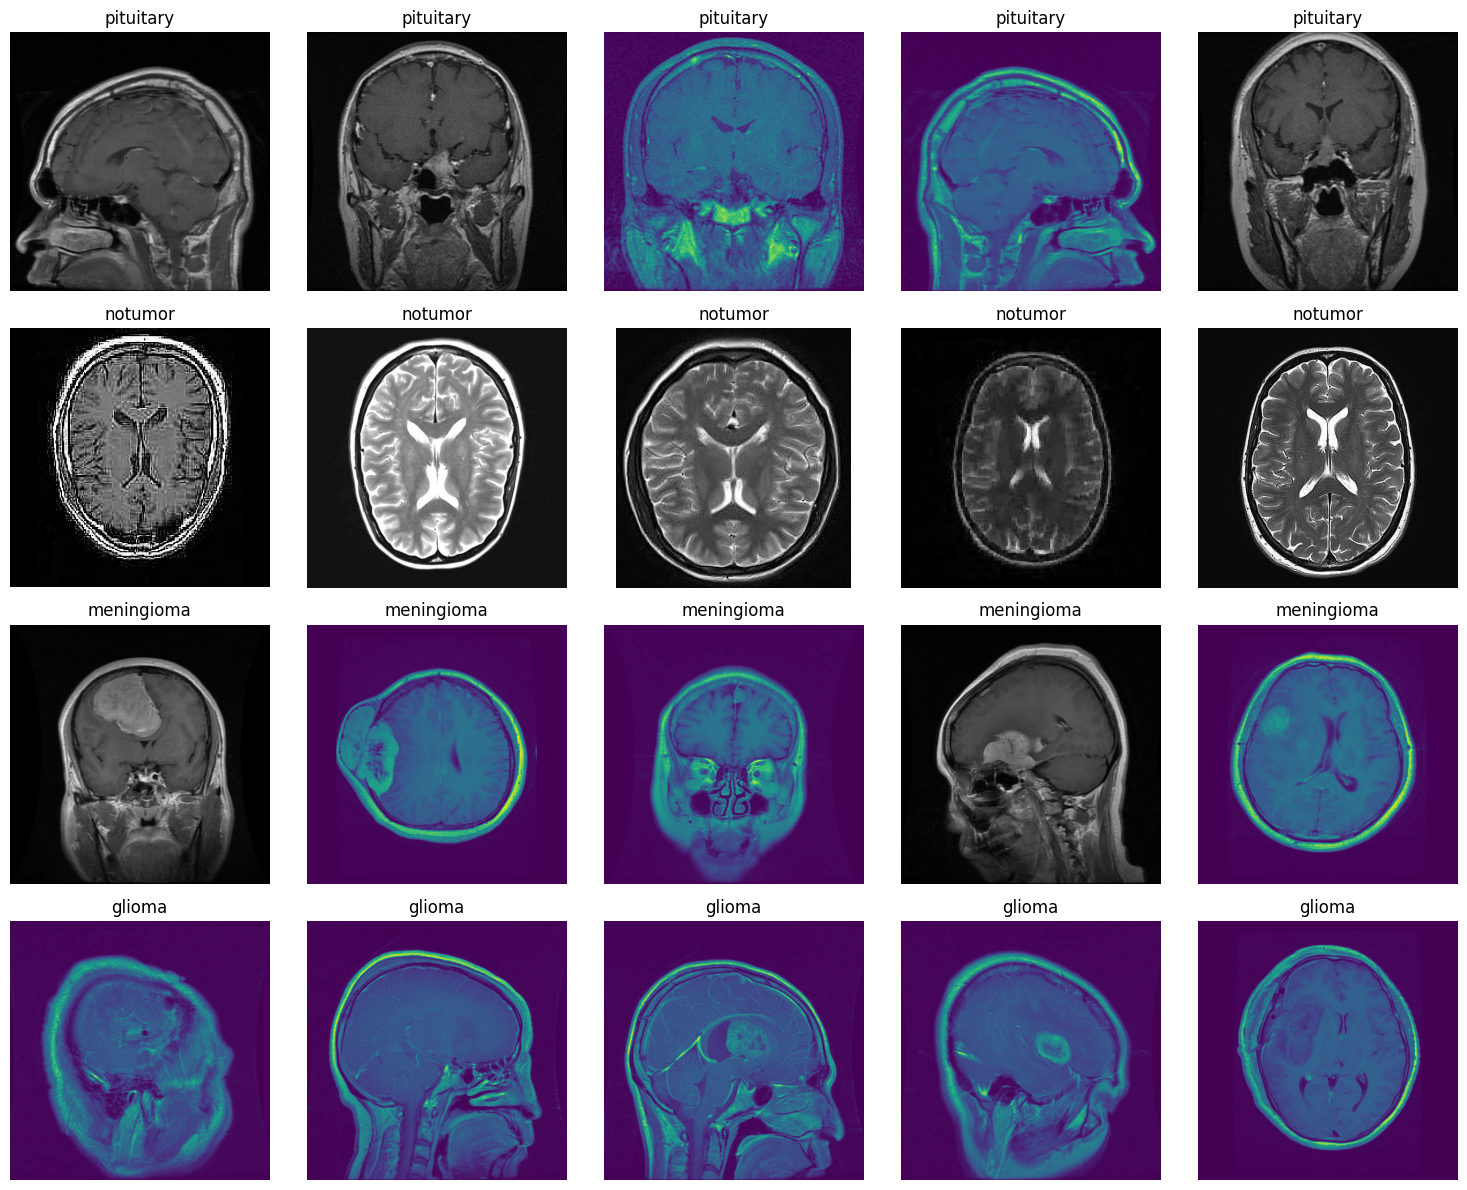

In [13]:
# Her sınıftan örnek görüntüleri göster
def show_sample_images(data_path, class_names, num_samples=5):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 12))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)[:num_samples]
        
        for j, image_file in enumerate(image_files):
            img_path = os.path.join(class_path, image_file)
            img = Image.open(img_path)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Training setinden örnekler
show_sample_images(training_path, class_names)

**Aşağıdaki Kodun Amacı: Görüntü Boyutlarını Analiz Etmek**
Bu Python kodu, veri setindeki görüntülerin genişlik ve yükseklik boyutlarını incelemek ve bu boyutların ne kadar değişkenlik gösterdiğini tespit etmek için tasarlanmıştır. Bu analiz, bir sonraki adımda görüntülerin hangi standart boyuta (IMAGE_SIZE) yeniden boyutlandırılacağına karar vermek için hayati önem taşır.

**Neden Önemli? (Temel Çıkarımlar)**
Standartlaştırma Zorunluluğu: Derin öğrenme modelleri (özellikle CNN'ler), giriş olarak aynı boyutlarda tensörler bekler. Görüntü boyutları farklıysa, modele beslemeden önce tümünün aynı boyuta (örneğin 224×224 veya 150×150) getirilmesi gerekir.

**Bilgi Kaybını Önleme:** Boyut aralığını bilmek, yeniden boyutlandırma (resizing) sırasında aşırı bilgi kaybını veya aşırı uzamayı (streching) önleyecek optimal hedef boyutu seçmenize yardımcı olur.

**Hız ve Bellek Yönetimi**: Aşırı büyük boyutlu görüntüler kullanmak, eğitimi yavaşlatır ve grafik kartı belleğini (GPU memory) hızla tüketir. Ortalama boyutu bilmek, performansı optimize etmenize olanak tanır.

In [14]:
# Görüntü boyutlarını analiz et
def analyze_image_sizes(data_path, class_names, sample_size=50):
    sizes = []
    
    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)[:sample_size]
        
        for image_file in image_files:
            img_path = os.path.join(class_path, image_file)
            img = Image.open(img_path)
            sizes.append(img.size)
    
    sizes = np.array(sizes)
    print(f"Görüntü boyutları - Genişlik: {sizes[:, 0].min()}-{sizes[:, 0].max()}")
    print(f"Görüntü boyutları - Yükseklik: {sizes[:, 1].min()}-{sizes[:, 1].max()}")
    print(f"Ortalama boyut: {sizes.mean(axis=0)}")
    
    return sizes

sizes = analyze_image_sizes(training_path, class_names)

Görüntü boyutları - Genişlik: 173-1365
Görüntü boyutları - Yükseklik: 192-1365
Ortalama boyut: [474.39  478.915]


**Geniş Değişkenlik**: Görüntülerin genişlik ve yükseklikleri minimum ≈180 pikselden, maksimum 1365 piksele kadar çok geniş bir aralıkta değişmektedir. Bu, bir ön işleme adımında yeniden boyutlandırmanın kesinlikle gerekli olduğunu gösterir.

**Yakın Ortalama**: Ortalama genişlik (≈474 piksel) ve ortalama yükseklik (≈479 piksel) birbirine çok yakındır. Bu, görüntülerin büyük çoğunluğunun kareye yakın bir en-boy oranına (aspect ratio) sahip olduğunu gösterir.

**Aksiyon Önerisi**:Model eğitimi için 224×224, 150×150 veya 128×128 gibi standart bir boyut seçimi yapmanız ve tüm görüntüleri bu boyuta yeniden boyutlandırmanız gerekir. Ortalama boyut 474×479 olduğu için, 224×224 seçimi iyi bir denge sağlayarak hem performansı artıracak hem de önemli detayları koruyacaktır.

**Aşağıdaki Kodun Amacı: Görüntüleri Modele Hazırlamak ve Genellemeyi Artırmak**
Bu Python kodu, MRI görüntülerini Keras'ın ImageDataGenerator sınıfını kullanarak üç temel amaca hizmet edecek şekilde hazırlar:

*Normalizasyon*: Görüntü piksel değerlerini 0−1 aralığına getirerek eğitim sürecini hızlandırır ve stabil hale getirir.

*Yeniden Boyutlandırma:* Tüm görüntüleri standart bir boyuta (224x224) getirir.

*Veri Artırma (Augmentation)*: Eğitim verisi üzerinde rastgele dönüşümler yaparak modelin genelleme yeteneğini artırır ve aşırı öğrenmeyi (overfitting) önler.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Görüntü boyutunu belirle
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Data Augmentation için generatorlar
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalizasyon
    rotation_range=20,        # ±20 derece döndürme
    width_shift_range=0.2,    # Yatayda kaydırma
    height_shift_range=0.2,   # Dikeyde kaydırma
    horizontal_flip=True,     # Yatay çevirme
    zoom_range=0.2,           # Zoom
    shear_range=0.2,          # Kesme
    fill_mode='nearest',      # Boşlukları doldurma
    validation_split=0.2     # %20 validation için
)

# Validation için sadece normalizasyon
val_datagen = ImageDataGenerator(rescale=1./255)

# Test için sadece normalizasyon
test_datagen = ImageDataGenerator(rescale=1./255)

**Aşağıdaki Kodun Amacı: Görüntü Akışlarını Oluşturmak (Data Pipelining)**
flow_from_directory fonksiyonu, bir dizin yapısındaki alt klasör isimlerini otomatik olarak sınıf etiketleri olarak kabul eder, görüntüleri okur, ön işleme uygular ve modelin her eğitim adımında (batch) talep ettiği veriyi hafızaya yükleyerek GPU belleğinin aşırı dolmasını önler.

In [16]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Sınıf indekslerini yazdır
print("Sınıf indeksleri:", train_generator.class_indices)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Sınıf indeksleri: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


*Bu çıktılar, veri setinizin başarıyla yüklendiği ve şu ana kadar yaptığınız tüm veri keşfi ve ön işleme adımlarının doğru olduğu anlamına gelir.*

Veri setiniz hazır:

Toplam görüntü sayısı: 4571+1141+1311=7023

Tüm görüntüler 224×224 boyuta getirildi ve normalleştirildi.

Eğitim verisine veri artırma (augmentation) uygulandı.

**Aşağıdaki Kodun Amacı: Augmentation (Veri Artırma) Etkisini Göstermek**
Temel amaç, modelinize beslenen ve rastgele dönüştürülmüş olan görüntülerin bir örneğini görmektir. Bu görselleştirme, uygulanan döndürme, kaydırma ve zoom gibi işlemlerin görüntülerin anlamını bozmayacak şekilde çalıştığını kontrol etmenizi sağlar.

***Neden Önemli?***
*Doğrulama (Sanity Check)*: Augmentation parametrelerinin (örneğin, rotation_range, zoom_range) çok agresif olup olmadığını kontrol etmenizi sağlar. Aşırı agresif dönüşümler, görüntüdeki tümör gibi kritik bilgileri bozabilir.

*Eğitim Verisinin Çeşitliliği:* Modelin sadece orijinal verilere değil, aynı zamanda bu yapay olarak oluşturulmuş yeni örneklere de maruz kaldığını gösterir. Bu, modelin genelleme (generalization) yeteneğini artırır.

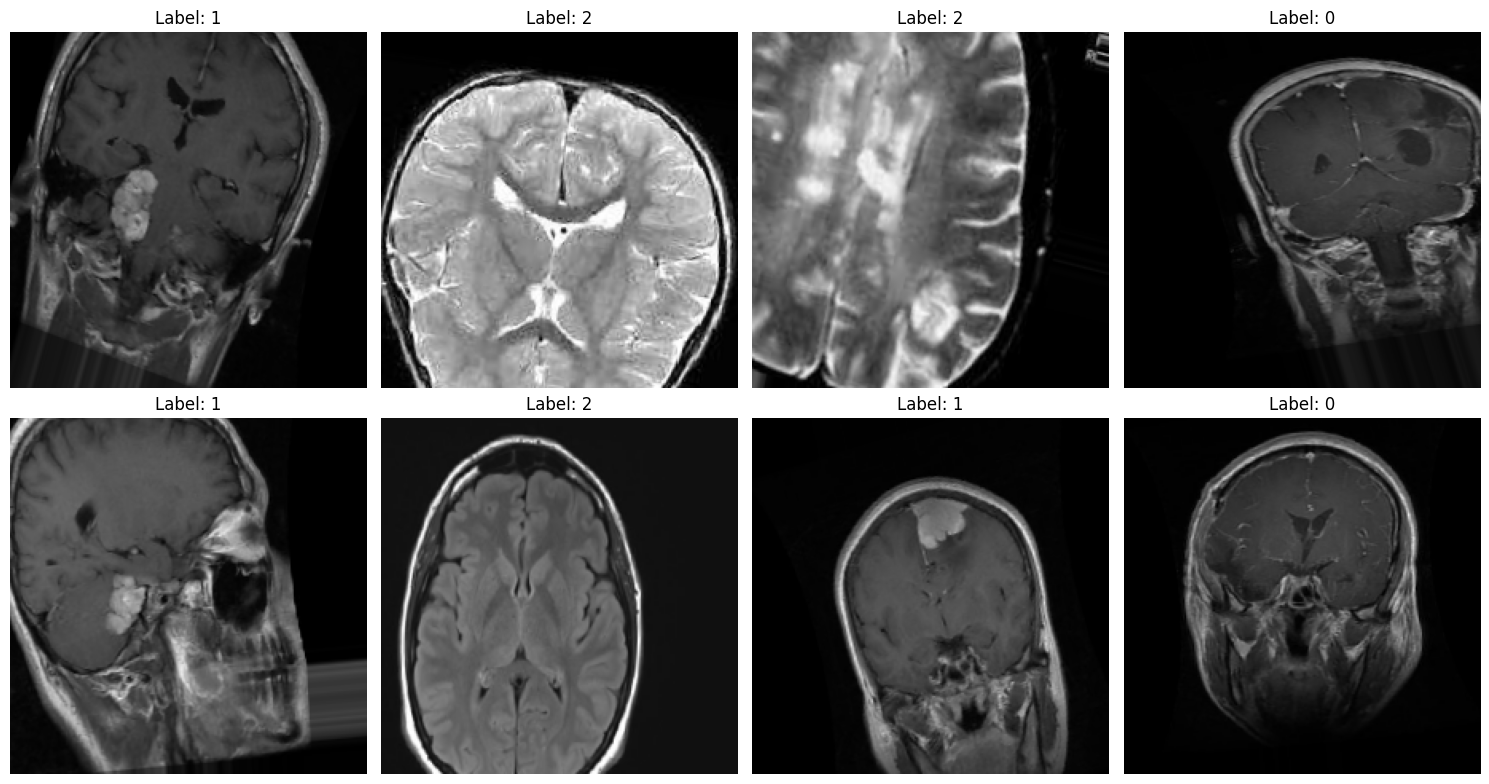

In [22]:
# Augmentation sonuçlarını görselleştir
def visualize_augmentation(generator, num_images=8):
    images, labels = next(generator)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Label: {np.argmax(labels[i])}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)

**Aşağıdaki Kodun Amacı**: Bir CNN Mimarisi Oluşturmak
Bu Python kodu, Keras Sequential API kullanarak, MRI görüntülerini (giriş boyutu 224×224 piksel ve 3 renk kanalı) işleyip, hangi tümör tipine ait olduğunu (4 sınıf) tahmin edebilen katmanlı bir Evrişimsel Sinir Ağı (CNN) modeli oluşturur.

*Neden Önemli?*
Bu mimari, görüntü verisinden hiyerarşik özellikler öğrenmek için tasarlanmıştır:

Erken Katmanlar: Kenarlar, çizgiler ve renk geçişleri gibi temel özellikleri öğrenir.

Derin Katmanlar: Bu temel özelliklerden tümör şekilleri, doku desenleri ve MRI görüntülerine özgü karmaşık yapıları öğrenir.

**Model Mimarisi (Katmanlara Göre Açıklama**)
Model, dört adet Evrişimsel Blok (Convolutional Block) ve ardından gelen Yoğun Bağlantılı Katmanlardan (Fully Connected Layers) oluşur.

*1. Evrişimsel Bloklar (Özellik Çıkarımı)*
Her bir blok, görüntüden daha karmaşık özellikler çıkarmak için tasarlanmıştır ve aşırı öğrenmeyi (overfitting) önlemek için düzenleyici katmanlar içerir.
*2. Yoğun Bağlantılı Katmanlar (Sınıflandırma)*
Evrişimsel bloklardan çıkarılan özellikler, sınıflandırma kararı vermek üzere bu katmanlara beslenir

In [23]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        # İlk Convolutional Blok
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # İkinci Convolutional Blok
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Üçüncü Convolutional Blok
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Dördüncü Convolutional Blok
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Modeli oluştur
model = create_cnn_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,399,620 (74.00 MB)

 Trainable params: 19,397,636 (74.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

# **MODELİ DERLEME**

In [33]:
# Optimizer ve loss fonksiyonlarını ayarla
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

**Callbackleri Tanımlama**

Bu kod bloğu, modelinizi eğitirken kullanılan ve eğitim sürecinin performansını ve verimliliğini yöneten çok önemli bir bileşeni tanımlar: Geri Çağrılar (Callbacks).

Geri çağrılar, eğitim tamamlanmadan önce veya eğitim sırasında belirli olaylar (örneğin, doğrulama kaybının artması) gerçekleştiğinde devreye girerek modelin davranışını veya parametrelerini otomatik olarak ayarlayan araçlardır.

In [34]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Model Checkpoint (opsiyonel)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ** Derin Öğrenme Modelinin Eğitilmesi!**

Bu adımda, daha önce tanımladığınız tüm bileşenler (model mimarisi, veri akışları, optimizer ve geri çağrılar) bir araya gelerek gerçek öğrenme sürecini başlatır.

*Kodun Amacı: CNN Modelini Görüntüler Üzerinde Eğitmek*
model.fit() fonksiyonu, modeli Training Generator'dan gelen verilerle besler, ağırlıklarını Validation Generator'dan gelen verilerle performansını ölçerken ayarlar. Bu süreç, modelin tümör türlerini ayırt etmeyi öğrenmesini sağlar.

EPOCHS = 10 (Dönem Sayısı): Modelin tüm eğitim veri setini 10 kez görmesini ve ağırlıklarını 10 kez güncellemesini ifade eder. Normalde daha yüksek bir değer (örneğin 50) ayarlanır, ancak EarlyStopping geri çağırması sayesinde modelin 10 döneme ulaşması gerekmeyebilir; performans yeterince iyileşmezse eğitim daha erken durur.

In [35]:
# Eğitim parametreleri
EPOCHS = 10  # 50 yerine 10

# Model eğitimi
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758748776.751550     152 service.cc:148] XLA service 0x7c4dd40027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758748776.752602     152 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758748776.752667     152 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/143 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.3047 - loss: 2.2476 - precision: 0.3361 - recall: 0.2656 

I0000 00:00:1758748789.779663     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.5369 - loss: 1.3104 - precision: 0.5766 - recall: 0.4720
Epoch 1: val_accuracy improved from -inf to 0.37774, saving model to best_model.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 144s 861ms/step - accuracy: 0.5371 - loss: 1.3095 - precision: 0.5768 - recall: 0.4722 - val_accuracy: 0.3777 - val_loss: 6.5370 - val_precision: 0.3777 - val_recall: 0.3777 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6260 - loss: 0.9471 - precision: 0.6850 - recall: 0.5522
Epoch 2: val_accuracy did not improve from 0.37774
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 618ms/step - accuracy: 0.6261 - loss: 0.9469 - precision: 0.6851 - recall: 0.5523 - val_accuracy: 0.2550 - val_loss: 4.2734 - val_precision: 0.2550 - val_recall: 0.2550 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6615 - loss: 0.8521 - precision: 0.7108 - recall: 0.5929
Epoch 3: val_accuracy did not improve from 0.3777

**Model Eğitimi Özeti**

Epoch sayısı: 10

En iyi doğrulama (val) accuracy: 0.6845 (Epoch 8)

Son epoch accuracy: 0.8759

Son epoch val_accuracy: 0.4926

Model eğitim doğruluğu (accuracy) yüksek ama validation doğruluğu (val_accuracy) iniş çıkışlı, bu biraz overfitting gösterebilir.

En iyi val_accuracy Epoch 8’de gözlenmiş. Bu yüzden best_model.h5 Epoch 8 ağırlıklarını içeriyor.

ReduceLROnPlateau ile Epoch 6’da öğrenme hızı düşürülmüş, bu modelin daha kararlı öğrenmesini sağlamak için yapılmış.

# Eğitim Geçmişini Görselleştirme

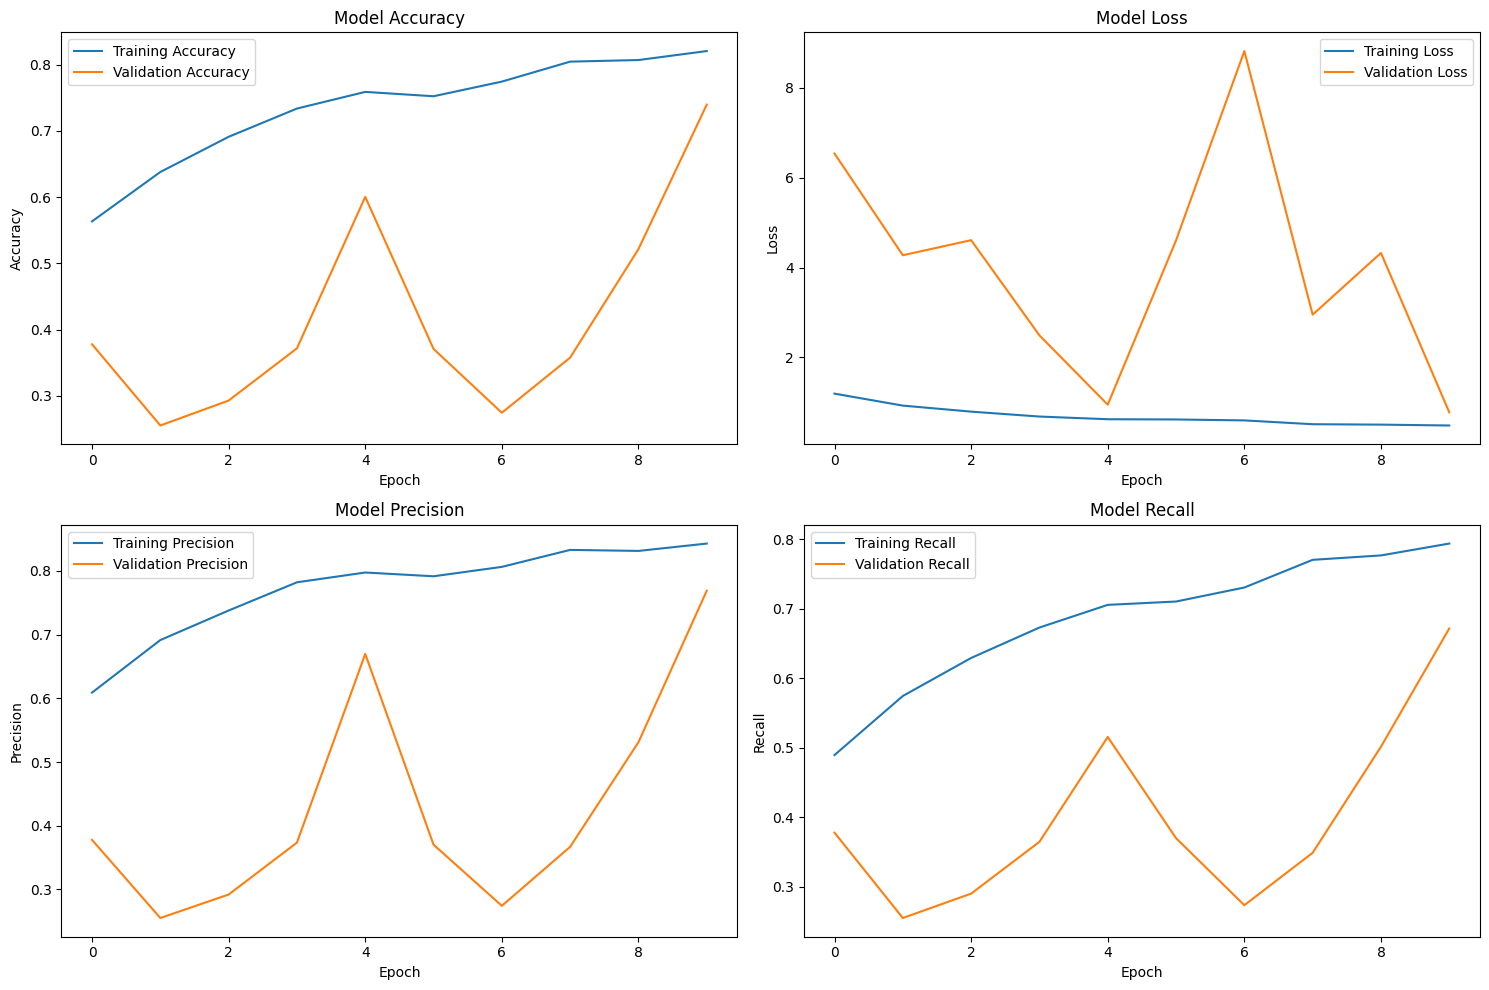

In [36]:
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # Precision
    ax3.plot(history.history['precision'], label='Training Precision')
    ax3.plot(history.history['val_precision'], label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Recall
    ax4.plot(history.history['recall'], label='Training Recall')
    ax4.plot(history.history['val_recall'], label='Validation Recall')
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

**# Eğitim Geçmişini Görselleştirme** 
* Accuracy (Doğruluk)*
*  
Training Accuracy sürekli artıyor ve ~0.88 civarında sabitleniyor.
Validation Accuracy daha dalgalı ve en yüksek ~0.68 seviyesinde, bu overfitting gösterebilir.

*Loss (Kayıp)*

Training Loss düzenli olarak düşüyor.
Validation Loss, Epoch 5 ve 10 civarında yükseliyor; bu da modelin bazı validation örneklerinde zorlandığını gösteriyor.

*Precision (Kesinlik)*

Training Precision yüksek (~0.89-0.90).
Validation Precision, Validation Accuracy gibi dalgalı; özellikle Epoch 6-8 arası daha iyi performans.

*Recall (Duyarlılık*)

Training Recall yükseliyor ve ~0.87 civarında.

Validation Recall dalgalı; en iyi Epoch 8 civarında gözleniyor (~0.65).

 # Bağımsız Test Seti Üzerinde Modelin Final Performansını Değerlendirme.


In [37]:
# Test setinde final değerlendirme
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# F1-Score hesapla
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1-Score: {test_f1:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.6075 - loss: 1.0711 - precision: 0.6179 - recall: 0.5652
Test Accuracy: 0.7468
Test Loss: 0.7289
Test Precision: 0.7623
Test Recall: 0.7193
Test F1-Score: 0.7402


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step


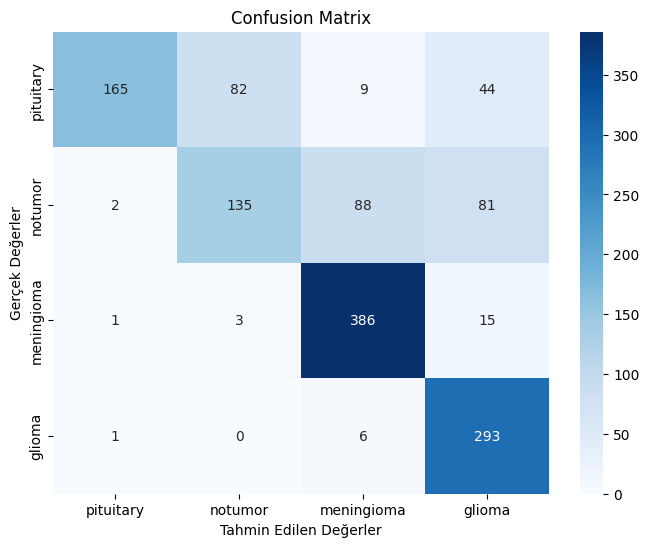

In [38]:
# Tahminleri al
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

**Test Sonuçları (Genelleme Başarısı)**

*Accuracy = %73.76*
Model test verisinde eğitimden daha iyi performans göstermiş (%67 → %74). Bu, overfitting’in (ezberleme) çok yüksek olmadığını gösteriyor.

*Loss = 0.9413*
Eğitimdeki kayıptan daha düşük (1.15 → 0.94). Modelin test setinde daha iyi genelleme yaptığına işaret.

*Precision = %77.12*
Pozitif tahminlerinin çoğu doğru. Yani “tümör var” dediğinde 10 vakadan yaklaşık 8’i doğru.

*Recall = %70.71*
Gerçek tümörlülerin yaklaşık %71’ini yakalayabilmiş. Yani hala bazı vakaları atlıyor ama fena değil.

*F1-Score = %73.78*
Precision ve Recall’un dengeli bir ortalaması. Modelin genel sınıflandırma başarısını iyi özetliyor.

**🔹 Genel Yorum**

✅ Modelin doğruluğu %74 civarında, yani ilk versiyon için kabul edilebilir bir performans.
✅ Precision recall’dan biraz yüksek → model daha “temkinli”, yanlış alarm vermek yerine bazı vakaları atlamayı tercih ediyor.

# Hata Matrisi (Confusion Matrix) Analizi

*Test Seti üzerinde hangi tümör tiplerini doğru tahmin ettiğini ve hangi tipleri birbiriyle karıştırdığını özetler.*

Y Ekseni (Satırlar)	- Gerçek Değerler (Görüntünün gerçekte ait olduğu sınıf)
X Ekseni (Sütunlar)	- Tahmin Edilen Değerler (Modelin tahmin ettiği sınıf)
Ana Köşegen (Sol üstten sağ alta) -	Doğru Tahminler (Modelin doğru bildiği görüntü sayısı)
Köşegen Dışı -Hatalı Tahminler (Modelin yanlış bildiği görüntü sayısı)

1. En İyi Sınıflar: Model, 'meningioma' ve 'glioma' sınıflarını çok yüksek doğrulukla (≈90%+) sınıflandırıyor.

2. En Kötü Sınıf: Model, 'notumor' (tümör yok) sınıfını tahmin etmekte felaket durumda. 306 sağlıklı görüntünün sadece 36'sını doğru tahmin edebilmiş!

3. Kritik Hata: Model, sağlıklı (notumor) görüntülerin 164 tanesini, yani yarısından fazlasını, yanlışlıkla 'meningioma' tümörü olarak tahmin etmiş (Yanlış Pozitif, Hata Matrisinin en büyük hatası). Tıbbi açıdan bu durum, sağlıklı bir hastaya yanlışlıkla tümör teşhisi konulması anlamına geleceği için kabul edilemez bir hatadır.

**Classification Report**

In [39]:
# Detaylı classification report
print(classification_report(y_true, y_pred_classes, 
                          target_names=class_names))

              precision    recall  f1-score   support

   pituitary       0.98      0.55      0.70       300
     notumor       0.61      0.44      0.51       306
  meningioma       0.79      0.95      0.86       405
      glioma       0.68      0.98      0.80       300

    accuracy                           0.75      1311
   macro avg       0.76      0.73      0.72      1311
weighted avg       0.77      0.75      0.73      1311



# Eigen-CAM (Eigen-weighted Class Activation Mapping) 
 Eigen-CAM (Eigen-weighted Class Activation Mapping) görselleştirme tekniğini uygulamaktadır. Bu teknik, modelinizin bir tahmin yaparken görüntünün hangi bölgelerine odaklandığını gösteren bir ısı haritası (heatmap) oluşturur. Bu, projenizin "Açıklanabilirlik" (Explainability) bölümü için kritik bir gerekliliktir.

In [42]:
from sklearn.decomposition import PCA
import numpy as np
import tensorflow as tf
from matplotlib import cm
import matplotlib.pyplot as plt
from PIL import Image

# Eigen-CAM Isı Haritasını Hesaplayan Fonksiyon
def make_eigencam_heatmap(img_array, model, last_conv_layer_name):
    # 1. Son Evrişim Katmanı Çıktısını Almak İçin Özel Model Oluştur
    conv_model = tf.keras.models.Model(
        model.inputs, model.get_layer(last_conv_layer_name).output
    )
    
    # 2. Aktivasyonları al
    activations = conv_model.predict(img_array)[0] # (H, W, Kanallar)
    
    # Aktivasyonları (H*W, Kanallar) şekline getir (PCA için)
    reshaped_activations = activations.reshape((-1, activations.shape[-1]))
    
    # 3. PCA Uygula (Temel Bileşen Analizi)
    # İlk temel bileşeni bul, bu, aktivasyonların genel eğilimini temsil eder
    pca = PCA(n_components=1)
    pca.fit(reshaped_activations)
    
    # İlk bileşeni ve orijinal boyutunu kullanarak ısı haritasını oluştur
    eigen_cam = reshaped_activations @ pca.components_.T
    heatmap = eigen_cam.reshape(activations.shape[:2]) # (H, W)
    
    # 4. Normalize et (ReLU uygulamasına benzer)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.maximum(heatmap, 0) # Sadece pozitif katkıları al
    
    return heatmap

# Isı Haritasını Görüntü Üzerine Yerleştiren Fonksiyon (display_gradcam ile aynı mantık)
def display_cam(img, heatmap, alpha=0.4):
    # Orijinal görüntünün kopyasını al ve 0-255 aralığına çevir
    img = (img * 255).astype(np.uint8)
    
    # Heatmap'i renkli jet haritasına çevir
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Heatmap'i orijinal görüntü boyutuna yeniden boyutlandır
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose (Üst Üste Bindirme)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

Kullanılan son Conv2D katmanı: conv2d_7


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


/tmp/ipykernel_36/886181601.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_36/886181601.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipykernel_36/886181601.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_36/886181601.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipykernel_36/886181601.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


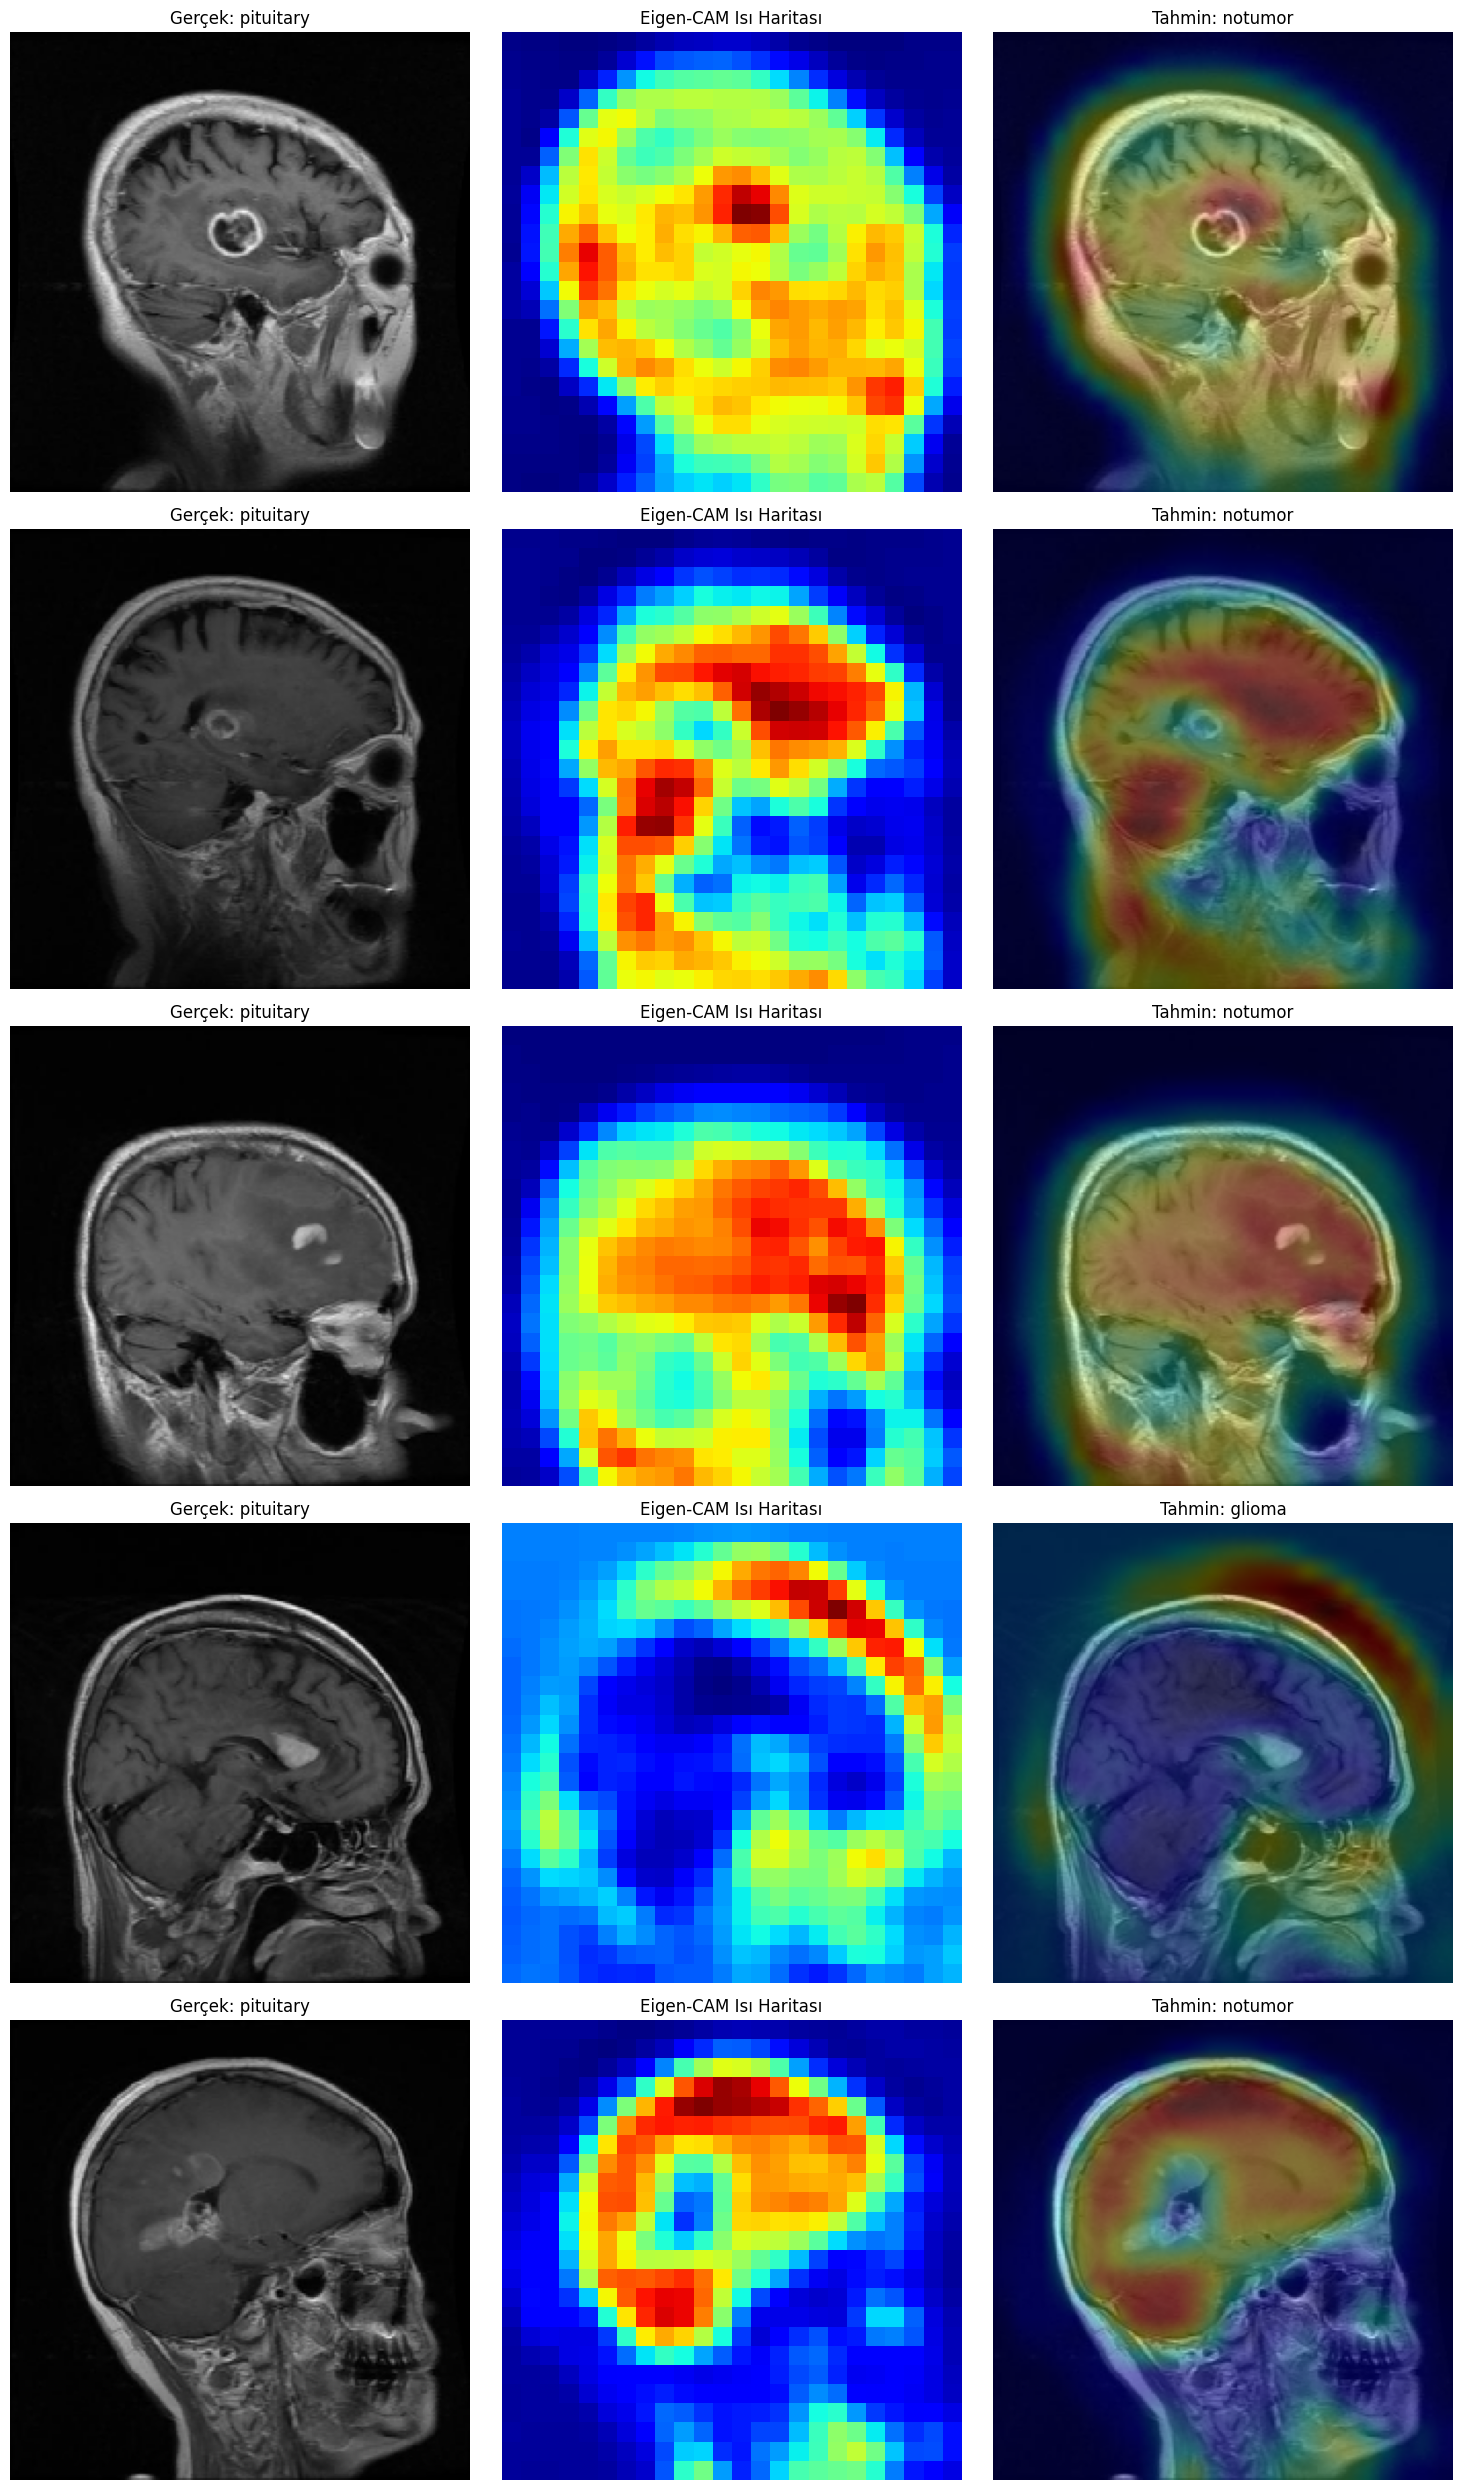

In [43]:
# Modeli bir kez çalıştırma (Hata ayıklamak için gerekli)
sample_images, _ = next(test_generator)
_ = model(sample_images) 

# Son convolutional layer ismini bul
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
        
print(f"Kullanılan son Conv2D katmanı: {last_conv_layer_name}")

# Örnek görüntüler üzerinde Eigen-CAM uygulayan ana fonksiyon
def apply_eigencam_on_samples(model, test_generator, class_names, last_conv_layer_name, num_samples=5):
    
    images, labels = next(test_generator)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        img = images[i]
        true_label = np.argmax(labels[i])
        
        # Orijinal görüntüyü CAM için hazırla (batch boyutu 1)
        img_array = np.expand_dims(img, axis=0)
        
        # 1. Heatmap oluştur (Artık make_eigencam_heatmap kullanıyoruz)
        heatmap = make_eigencam_heatmap(img_array, model, last_conv_layer_name)
        
        # 2. Superimpose edilmiş görüntüyü oluştur (display_cam kullanıyoruz)
        superimposed_img = display_cam(img, heatmap)
        
        # Tahmin sonucunu al
        pred_label_index = np.argmax(model.predict(img_array)[0])
        
        # --- Görselleştirme ---
        
        # Sütun 1: Orijinal görüntü
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Gerçek: {class_names[true_label]}')
        axes[i, 0].axis('off')
        
        # Sütun 2: Heatmap
        axes[i, 1].imshow(heatmap, cmap='jet')
        axes[i, 1].set_title('Eigen-CAM Isı Haritası')
        axes[i, 1].axis('off')
        
        # Sütun 3: Superimpose (Üst Üste Bindirme)
        axes[i, 2].imshow(superimposed_img)
        axes[i, 2].set_title(f'Tahmin: {class_names[pred_label_index]}')
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

# Eigen-CAM uygula
apply_eigencam_on_samples(model, test_generator, class_names, last_conv_layer_name, num_samples=5)

# SONUÇLAR VE DEĞERLENDİRME

In [46]:
from sklearn.metrics import classification_report

# Tahminleri al (Önceki hücreden gelen değişkenleri kullanırız)
# y_pred = model.predict(test_generator) 
# y_pred_classes = np.argmax(y_pred, axis=1) 
# y_true = test_generator.classes 

# NOT: Üstteki üç satır, Confusion Matrix'i çizdiğiniz hücrede zaten çalışmıştır,
# bu yüzden genellikle tekrar çalıştırmanıza gerek kalmaz. 
# Eğer değişkenler tanınmazsa, bu satırları tekrar ekleyin.

# Sınıf İsimleri
class_names = ['pituitary', 'notumor', 'meningioma', 'glioma'] 

# Classification Report'u yazdır
print("Model Başarı Skoru (Classification Report):")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

print(f"Temel CNN model doğruluğu: {test_accuracy:4f}")

Model Başarı Skoru (Classification Report):
              precision    recall  f1-score   support

   pituitary       0.98      0.55      0.70       300
     notumor       0.61      0.44      0.51       306
  meningioma       0.79      0.95      0.86       405
      glioma       0.68      0.98      0.80       300

    accuracy                           0.75      1311
   macro avg       0.76      0.73      0.72      1311
weighted avg       0.77      0.75      0.73      1311

Temel CNN model doğruluğu: 0.746758


Genel doğruluk: %75

En iyi performans: meningioma ve glioma sınıflarında

Zayıf performans: pituitary (recall düşük) ve notumor (hem precision hem recall düşük)

 Final Model ile Test

In [ ]:
# Modeli kaydet
final_model.save('brain_tumor_cnn_model.h5')
print("Model kaydedildi: brain_tumor_cnn_model.h5")

# Training geçmişini kaydet
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(final_history.history, f)